In [1]:
import os
import operator
import random

import pandas as pd
import numpy as np
import tensorflow.contrib.keras as keras
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

from vixstructure.utils import parse_model_repr
from vixstructure.data import LongPricesDataset

## Experiment 01

Searching for optimal network depth and width.

In [2]:
directory, _, files = next(os.walk("models/experiment01"))
h5_files = tuple(file for file in files if os.path.splitext(file)[1] == ".h5")
csv_files = tuple(file for file in files if os.path.splitext(file)[1] == ".csv")

In [3]:
stats = [(parse_model_repr(os.path.splitext(file)[0]),
          pd.read_csv(os.path.join(directory, file), header=0, index_col=0,
                      dtype={"epoch":int, "loss":np.float32, "val_loss":np.float32,
                             "denorm_mse":np.float32, "val_denorm_mse":np.float32}))
         for file in csv_files]

In [4]:
parameters, stats_data = zip(*stats)

In [5]:
# Just look at the denormalized metrics because they have to be comparable.
for d in stats_data:
    if len(d.columns) == 2:
        use_this_as_columns = d.columns
        print(use_this_as_columns)
        break
for d in stats_data:
    if len(d.columns) == 4:
        d.drop(["loss", "val_loss"], axis=1, inplace=True)
        d.columns = use_this_as_columns

Index(['loss', 'val_loss'], dtype='object')


In [6]:
dataframe = pd.concat(stats_data, keys=[(p.depth, p.width, p.normalized) for p in parameters],
                      names=["depth", "width", "normalized"])

In [7]:
dataframe_basic = dataframe.xs(False, level="normalized")
dataframe_basic.sort_index(level=0, inplace=True)
dataframe_normal = dataframe.xs(True, level="normalized")
dataframe_normal.sort_index(level=0, inplace=True)

/home/leyht/bachelorthesis/vix-term-structure/venv/lib/python3.5/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/leyht/bachelorthesis/vix-term-structure/venv/lib/python3.5/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [8]:
print(dataframe_basic.min(), dataframe_basic.idxmin(), sep="\n")
print(dataframe_normal.min(), dataframe_normal.idxmin(), sep="\n")

loss        0.039264
val_loss    0.074803
dtype: float32
loss        (7, 24, 951)
val_loss    (3, 21, 700)
dtype: object
loss        0.034753
val_loss    0.081529
dtype: float32
loss        (9, 24, 957)
val_loss    (1, 21, 907)
dtype: object


### Mean validation loss and corresponding standard derivation

In [9]:
def reduce_mean_std(dataframe):
    groups = dataframe.groupby(("depth", "width", "epoch"))
    mean = groups.mean()
    std = groups.std()
    return pd.concat((mean, std), axis=1, keys=("mean", "std"))

In [10]:
reduced_basic = reduce_mean_std(dataframe_basic)
reduced_normal = reduce_mean_std(dataframe_normal)

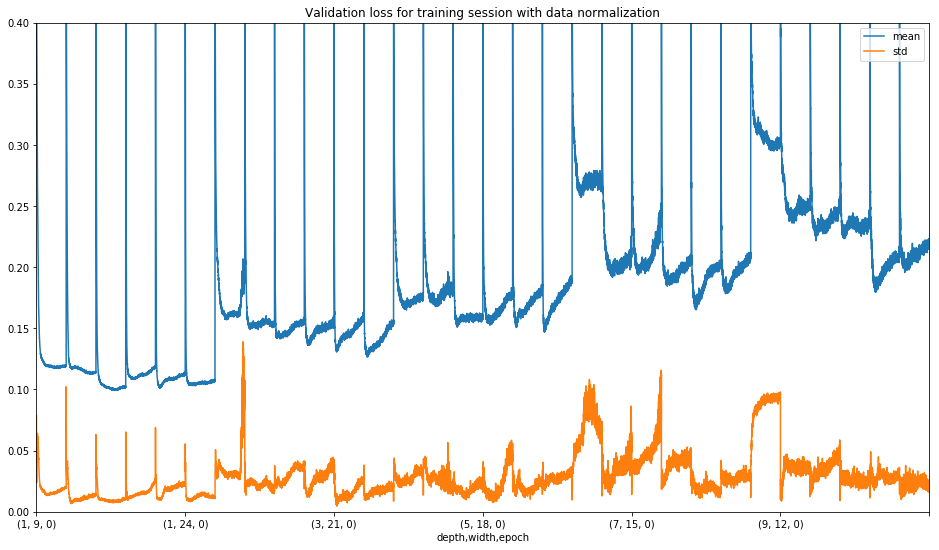

In [11]:
reduced_normal["mean", "val_loss"].plot(figsize=(16,9))
reduced_normal["std", "val_loss"].plot()
plt.legend(("mean", "std"))
plt.title("Validation loss for training session with data normalization")
plt.ylim(0, 0.4)
plt.show()

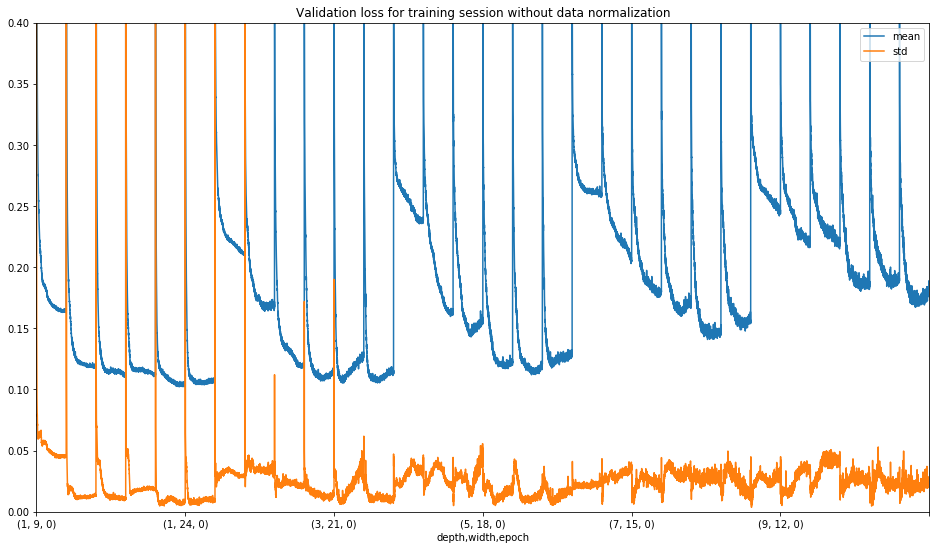

In [12]:
reduced_basic["mean", "val_loss"].plot(figsize=(16,9))
reduced_basic["std", "val_loss"].plot()
plt.legend(("mean", "std"))
plt.ylim(0, 0.4)
plt.title("Validation loss for training session without data normalization")
plt.show()

In [13]:
print("These are for not normalized training data:")
print(reduced_basic.min(), reduced_basic.idxmin(), sep="\n")
print(reduced_basic["std", "val_loss"][1, 21, 806])
print("And these are if training data got normalized beforehand:")
print(reduced_normal.min(), reduced_normal.idxmin(), sep="\n")
print(reduced_normal["std", "val_loss"][1, 15, 620])

These are for not normalized training data:
mean  loss        0.048656
      val_loss    0.102239
std   loss        0.002536
      val_loss    0.003677
dtype: float32
mean  loss        (9, 24, 978)
      val_loss    (1, 21, 806)
std   loss        (9, 21, 819)
      val_loss      (9, 9, 26)
dtype: object
0.00700229
And these are if training data got normalized beforehand:
mean  loss        0.043701
      val_loss    0.099223
std   loss        0.001100
      val_loss    0.004615
dtype: float32
mean  loss        (9, 24, 961)
      val_loss    (1, 15, 620)
std   loss        (3, 24, 672)
      val_loss     (3, 21, 95)
dtype: object
0.00862883


### Visualization of loss while looking at network depth and width

In [14]:
def plot3d_loss(dataframe, metric: str, loss: str, zlim=(0.1,0.25)):
    min_loss = dataframe.groupby(("depth", "width")).min()
    X = min_loss.index.levels[0]
    Y = min_loss.index.levels[1]
    X, Y = np.meshgrid(X, Y)
    Z = np.reshape(
            np.array(list(map(lambda x: min_loss[metric, loss][x[0], x[1]], np.reshape(np.dstack((X,Y)), (30,2))))),
            X.shape)
    fig = plt.figure(figsize=(8, 8))
    ax = fig.gca(projection='3d')
    ax.plot_wireframe(X, Y, Z, linewidth=None, antialiased=True)
    ax.view_init(azim=225)
    ax.set_xlabel("Depth")
    ax.set_ylabel("Width")
    ax.set_xlim(X[0,0], X[-1,-1])
    ax.set_ylim(Y[0,0], Y[-1,-1])
    ax.set_zlim(zlim)
    ax.set_zlabel("Loss", rotation=90)

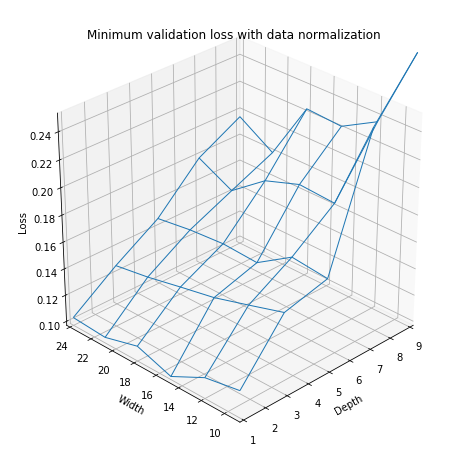

In [15]:
plot3d_loss(reduced_normal, "mean", "val_loss")
plt.title("Minimum validation loss with data normalization")
plt.show()

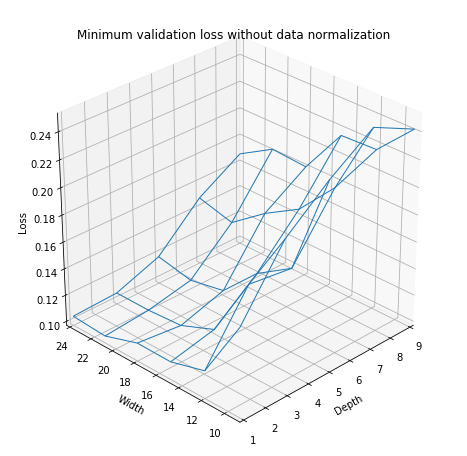

In [16]:
plot3d_loss(reduced_basic, "mean", "val_loss")
plt.title("Minimum validation loss without data normalization")
plt.show()

### How did the good models converge?

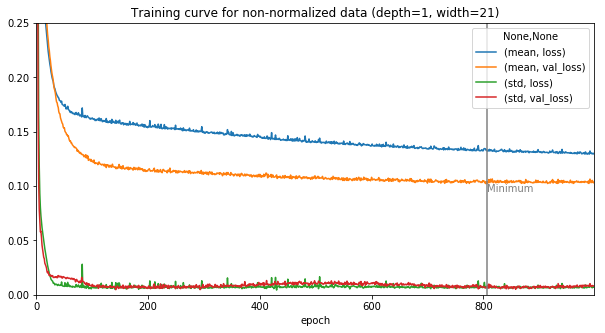

In [17]:
reduced_basic.loc[1, 21].plot(figsize=(10,5))
plt.ylim(0, 0.25)
plt.axvline(806, color="grey")
plt.text(806, 0.102239, "Minimum", va="top", color="grey")
plt.title("Training curve for non-normalized data (depth=1, width=21)")
plt.show()

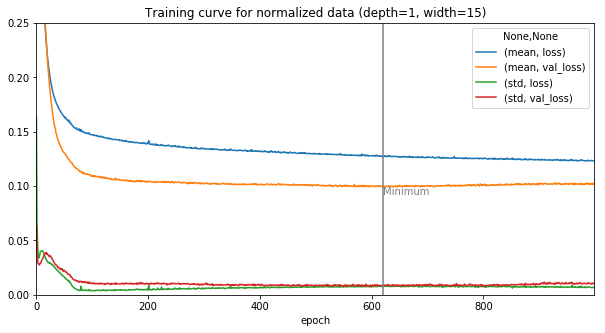

In [18]:
reduced_normal.loc[1, 15].plot(figsize=(10,5))
plt.ylim(0.0, 0.25)
plt.axvline(620, color="grey")
plt.text(620, 0.099223, "Minimum", va="top", color="grey")
plt.title("Training curve for normalized data (depth=1, width=15)")
plt.show()

In [19]:
ep5000 = pd.read_csv("models/experiment00/20170705164318_schumpeter_depth1_width15_dropout0e+00_optimAdam_lr1e-03_normalized.csv",
                     header=0, index_col=0, dtype={"epoch":int, "loss":np.float32, "val_loss":np.float32,
                                                   "denorm_mse":np.float32, "val_denorm_mse":np.float32})

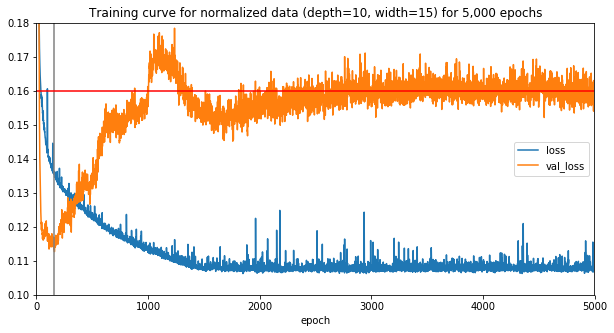

In [20]:
ep5000["denorm_mse"].plot(figsize=(10,5))
ep5000["val_denorm_mse"].plot()
plt.ylim(0.1, 0.18)
plt.axvline(ep5000["val_denorm_mse"].idxmin(), color="grey")
plt.axhline(ep5000["val_denorm_mse"][2500:].mean(), color="red")
plt.title("Training curve for normalized data (depth=10, width=15) for 5,000 epochs")
plt.legend(("loss", "val_loss"))
plt.show()

### Looking at the predictions itself

In [21]:
model_ex1_basic = keras.models.load_model("models/experiment01/20170703151236_tfpool18_depth1_width21_dropout0e+00_optimAdam_lr1e-03.h5")
dataset = LongPricesDataset("data/8_m_settle.csv", "data/expirations.csv")
(x_train, y_train), (x_val, y_val), (x_test, y_test) = dataset.splitted_dataset()

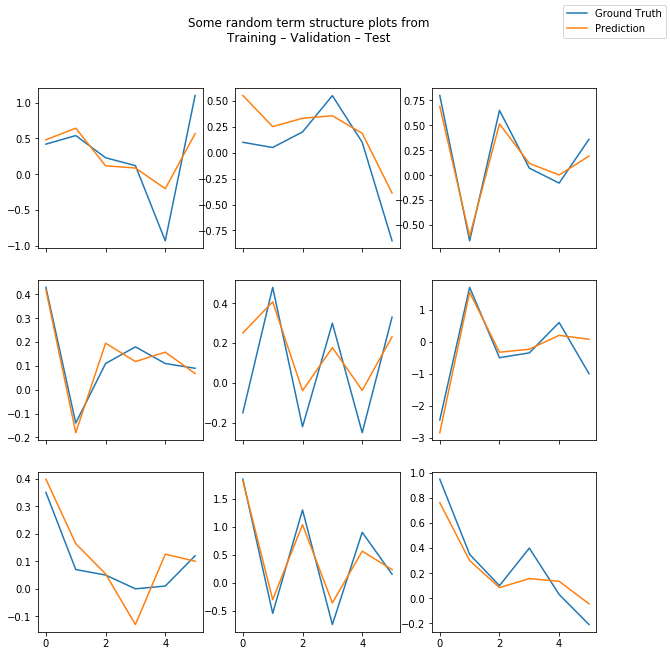

In [22]:
fig, axs = plt.subplots(3, 3, sharex=True, figsize=(10,10))
for axh in axs:
    i1 = random.randint(0, len(x_train) - 1)
    axh[0].plot(np.arange(6), y_train[i1],
                np.arange(6), np.squeeze(model_ex1_basic.predict(np.expand_dims(x_train[i1], axis=0))))
    i2 = random.randint(0, len(x_val) - 1)
    axh[1].plot(np.arange(6), y_val[i2],
                np.arange(6), np.squeeze(model_ex1_basic.predict(np.expand_dims(x_val[i2], axis=0))))
    i3 = random.randint(0, len(x_test) - 1)
    a,b = axh[2].plot(np.arange(6), y_test[i3],
                np.arange(6), np.squeeze(model_ex1_basic.predict(np.expand_dims(x_test[i3], axis=0))))
plt.suptitle("Some random term structure plots from\nTraining – Validation – Test")
fig.legend((a, b), ("Ground Truth", "Prediction"))
plt.show()

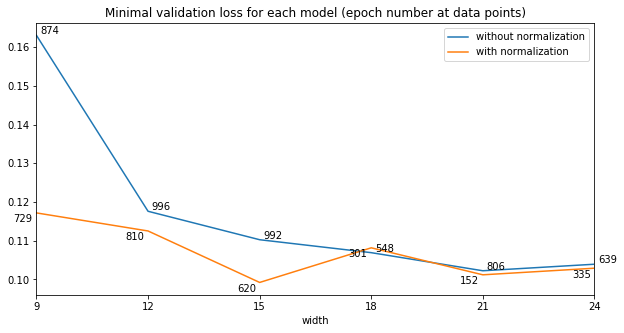

In [23]:
best_epochs_raw = reduced_basic["mean", "val_loss"].groupby("width").min()
best_epochs_normal = reduced_normal["mean", "val_loss"].groupby("width").min()
best_epochs = pd.concat((best_epochs_raw, best_epochs_normal), axis=1, keys=["without normalization", "with normalization"])
best_epochs.plot(figsize=(10,5))
for _, argmin_width, argmin_epoch in reduced_basic["mean", "val_loss"].groupby("width").idxmin():
    plt.text(argmin_width+0.1, best_epochs_raw[argmin_width]+0.0003, argmin_epoch)
for _, argmin_width, argmin_epoch in reduced_normal["mean", "val_loss"].groupby("width").idxmin():
    plt.text(argmin_width-0.1, best_epochs_normal[argmin_width]-0.0003, argmin_epoch, va="top", ha="right")
plt.title("Minimal validation loss for each model (epoch number at data points)")
plt.xticks(np.arange(9, 24+1, 3))
plt.show()

In [24]:
pd.concat((best_epochs_raw, best_epochs_normal), axis=1, keys=["without normalization", "with normalization"])

,without normalization,with normalization
width,,
9,0.163017,0.117177
12,0.117598,0.112512
15,0.110254,0.099223
18,0.106911,0.108167
21,0.102239,0.101194
24,0.103928,0.102903


In [28]:
print(dataframe.min(), dataframe.idxmin(), sep="\n")

loss        0.034753
val_loss    0.074803
dtype: float32
loss         (9, 24, True, 957)
val_loss    (3, 21, False, 700)
dtype: object
